# Regression Model on Multicollinary Dataset

## MachineHack Weekend Hackathon #13

### Power Plant Energy Output Prediction

### Overview

The dataset was collected from a Combined Cycle Power Plant over 6 years (2006-2011) when the power plant was set to work with a full load. Features consist of hourly average ambient variables *Temperature (T), Ambient Pressure (AP), Relative Humidity (RH)*, and *Exhaust Vacuum (V)* to predict the net hourly electrical energy output (PE) of the plant.
A combined-cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST), and heat recovery steam generators.

In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is collected from and has an effect on the Steam Turbine, the other three of the ambient variables affect the GT performance.

## 0. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

# Boosting algorithm
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [ ]:
# Explore the input dir
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1. Load dataset

In [ ]:
train_data = pd.read_csv('/kaggle/input/ccpp-data/Train.csv', header=0)
test_data = pd.read_csv('/kaggle/input/ccpp-data/Test.csv', header=0)
submit_data = pd.read_csv('/kaggle/input/ccpp-data/sample_submission.csv', header=0)

In [ ]:
# View basic details of the dataset
def view_details(dataframe):
    print()
    dataframe.info()
    print("--"*30)
    print(dataframe.head())

    
view_details(train_data)
view_details(test_data)
view_details(submit_data)

## 2. Exploratory Data Analysis

In [ ]:
# Statistic describtion of the dataset
train_data.describe()

**Visualize the dataset in one-shot using Pair plot**

In [ ]:
plt.figure(figsize=(12,6))

sns.pairplot(train_data, diag_kind='hist')

plt.tight_layout()
plt.show()

**Null or missing value check**

In [ ]:
print("Is there a null value in Train data? {}".format(train_data.isnull().sum().any()))
print("Is there a null value in Test data? {}".format(test_data.isnull().sum().any()))

**Correlation between attributes**

In [ ]:
# Compute correlation between the variables
corr = train_data.corr()


plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True)
plt.show()

In [ ]:
# Peason correlation calculation
for i in range(train_data.shape[1]-1):
    feature = train_data.columns[i]
    X = train_data[feature].values
    y = train_data['PE']
    r = np.round(pearsonr(X, y),2)
    print(f"Feature PE vs {feature}: r-value : {r}")

## 3. Feature Engineering

**Interactive Features by Polynomial function**

In [ ]:
train_data['train_or_test'] = 1
test_data['train_or_test'] = 0

# Combining train and test data
combined_set = pd.concat([train_data, test_data])

feature_cols = ['AT', 'V', 'AP', 'RH']
poly_cols = ['Coff','AT', 'V', 'AP', 'RH', 'AT2', 'AT*V', 'AT*AP', 'AT*RH', 'V2', 'V*AP', 'V*RH', 'AP2', 'AP*RH', 'RH2']
X = combined_set[feature_cols]
# Invoking polynomial feature transform method with degree of 2 for two variables
poly_reg = PolynomialFeatures(degree=2, interaction_only=False)
X_poly = poly_reg.fit_transform(X)

# Converting array into a Dataframe
X_poly = pd.DataFrame(X_poly, columns=poly_cols, index=combined_set.index)

X_poly['train_or_test'] = combined_set['train_or_test']

In [ ]:
X_poly.head()

In [ ]:
train_enc, test_enc = X_poly.loc[X_poly['train_or_test'] == 1], X_poly.loc[X_poly['train_or_test'] == 0]

**Split the data into Train and Validation set**

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_enc, train_data['PE'], test_size=0.2, random_state=42)

**Feature Selection using RandomForest Regressor**

In [ ]:
# Random forest regressor model to fit the split data
rnf = RandomForestRegressor(n_estimators=300)

rnf.fit(X_train, y_train)

In [ ]:
y_preds = rnf.predict(X_valid)

print("RMSE : {:.3f} ".format(mean_squared_error(y_valid, y_preds, squared=False)))
# print("RMSLE : {np.sqrt(mean_squared_log_error(y_valid, y_preds))}")

In [ ]:
X_train.columns

In [ ]:
rnf.feature_importances_

In [ ]:
imp_features = list(zip(X_train.columns, rnf.feature_importances_))
sorted(imp_features, key=lambda x: x[1], reverse=True)

## Target Variable Transformation

The target variable **PE** shows the Bimodel distribution. We need to transform this to uniform distribution to improve the model performance. 

In [ ]:
# Checking the target value skewness
y_target = train_data['PE'].values

y_data = y_target.reshape(len(y_target), 1)

# QuantileTransformer to make bimodel to uniform
quant_trans = QuantileTransformer(n_quantiles=300, output_distribution='uniform')

y_trans = quant_trans.fit_transform(y_data)

In [ ]:

fig, axes = plt.subplots(1,2,figsize=(10,6))

sns.distplot(y_target, kde=True, ax=axes[0])
sns.distplot(y_trans, kde=True, ax=axes[1])

plt.tight_layout()
plt.show()

## Feature Scaling

In [ ]:
imp_features = ['AT','V', 'AP','AT*V', 'AT*AP', 'AT*RH']
# feature_cols = ['AT', 'AP', 'RH']
X = train_enc[imp_features]
# y = train_enc['y_trans']
y = train_data['PE']
X_test = test_enc[imp_features]

In [ ]:
# StandardScaler to scale the variable values
scaler = StandardScaler().fit(X)

X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

X_scaled_df = pd.DataFrame(X_scaled, columns=imp_features)

## Model Building

In [ ]:
lgb_params={
    'learning_rate': 0.1,
    'objective':'regression',
    'importance_type':'split',
    'metric':'rmse',
    'num_leaves': 31,
    "random_state":42,
    'max_depth': 8,
    "bagging_seed" : 42,
    "bagging_frequency" : 5,
    "reg_alpha":0.0,
    "reg_lambda":0.0,
    'min_child_samples': 20,
    'min_child_weight':1
}

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_weight': 1
}

In [ ]:
# Boosting algorithms

lgbm = LGBMRegressor(**lgb_params, n_estimators=900)

xgb = XGBRegressor(**xgb_params, n_estimators=700)

In [ ]:
K = 5
kfolds = KFold(n_splits=K, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(kfolds.split(X_scaled_df)):
    
    y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]
    X_train, X_valid = X_scaled_df.iloc[train_idx, :], X_scaled_df.iloc[test_idx, :]
    
    print( "\nFold ", i)
    print("-"* 20 + "LGBM Regression" + "-"* 20)
    lgbm.fit(X_train, y_train, 
             eval_metric='rmse',
             eval_set=[(X_valid,  y_valid)],
            early_stopping_rounds=20,
            verbose=100)
    
    print("-"* 20 + "XGB Regression" + "-"* 20)
    xgb.fit(X_train, y_train, 
             eval_metric='rmse',
             eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=20,
            verbose=100)

**Predicting Test Data**

In [ ]:
X_test_df = pd.DataFrame(X_test_scaled, columns=imp_features)

# Invoking model predict method
lgb_preds = lgbm.predict(X_test_df)
xgb_preds = xgb.predict(X_test_df)

**Weighted Average Ensemble**

In [ ]:
boost_1, boost_2 = 0.3, 0.7 

preds_1 = boost_1 * lgb_preds
preds_2 = boost_2 * xgb_preds

predictions = preds_1 + preds_2

In [ ]:
predictions

## Final Submission

In [ ]:
final_df = pd.DataFrame(np.round(predictions, 6), columns=['PE'])

final_df.to_csv('powerplant_linear_01.csv', index=False)

## Conclusion

One of the primary observations on the dataset was that the dataset had only numerical variables and there are variables which directly involve in calculation of Energy output(PE). 

The estimation of Electrical Energy output (PE) is dependent on all the given factors(variables). This involves certain scientific methods and formula to obtain PE value. That is one of the key aspects to be considered in the feature engineering. We should include the required feature, which can be derived from the existing features. 

### Learnings:
1. We should check the domain objective of the Target variable data. In this case, PE can be calculated with the given feature data and derived data.
2. Is there a way we can derive a new feature. For ex, Dew Point is one of the critical feature for estimating PE.
3. Interactive features play a major role in reducing bias.
4. Bimodel distribution of data can be transformed to uniform or normal distribution using Quantile transformation.

The final score of this submission are as follows, 

Private score : **2.45**

Public Score: **2.51**

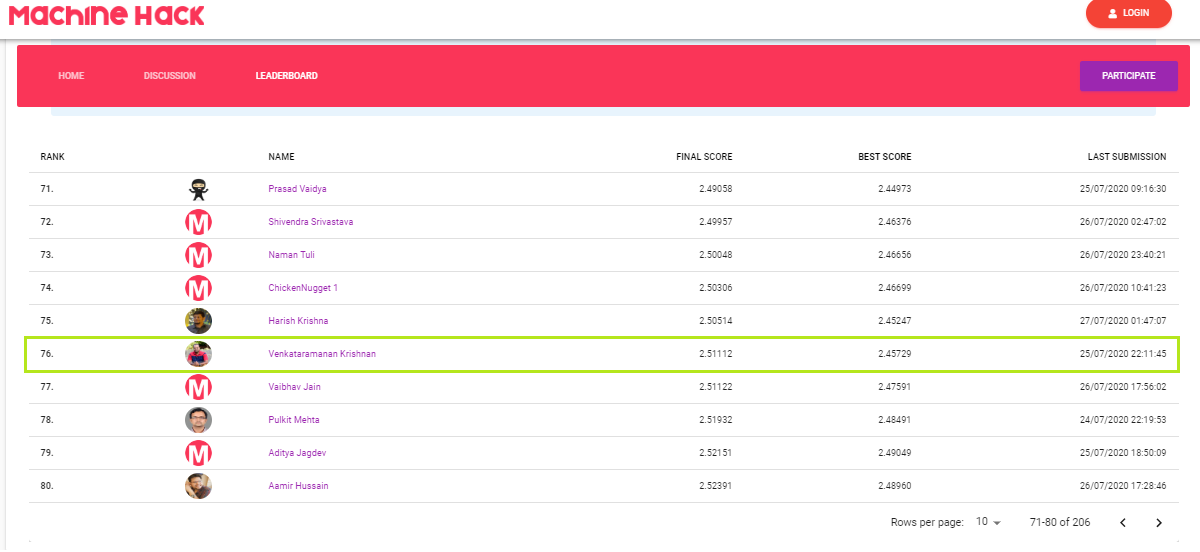